# Exercise 04 - Due Saturday, November 18 at 12pm

*Objectives*: Gain experience loading a CSV dataset into a star schema. Explore the data by writing and executing a number of SQL queries using common syntax and functions and describing your findings.

*Grading criteria*: The tasks should all be completed, and questions should all be answered with SQL queries in the space provided, unless a text answer is requested. Results should be correct, according to the embedded tests. The notebook itself should be completely reproducible; from start to finish, another person should be able to use the same code to obtain the same results as yours.  Note that you will receive no more than partial credit if you do not add text/markdown cells explaining your thinking at each major step in each problem.

** Add your markdown and code cells only in the designated areas after "Answers:". Do not remove or change any existing cells. **

*Deadline*: Monday, November 26, 1:00pm.

## Setup - obtain data

The US City Open Data Census has data on [Campaign Finance Contributions](http://us-city.census.okfn.org/dataset/campaign-finance).  Let's take a look at data from [Washington DC](http://opendata.dc.gov/datasets/campaign-financial-contributions).

First we download the dataset:

In [1]:
!wget -O dc_contributions.csv https://opendata.arcgis.com/datasets/6443e0b5b2454e86a3208b8a38fdee84_34.csv

--2018-11-26 00:59:52--  https://opendata.arcgis.com/datasets/6443e0b5b2454e86a3208b8a38fdee84_34.csv
Resolving opendata.arcgis.com (opendata.arcgis.com)... 35.171.60.143, 34.195.79.20
Connecting to opendata.arcgis.com (opendata.arcgis.com)|35.171.60.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘dc_contributions.csv’

dc_contributions.cs     [     <=>            ]  60.76M  75.6MB/s    in 0.8s    

2018-11-26 00:59:53 (75.6 MB/s) - ‘dc_contributions.csv’ saved [63717222]



## Part 1 - examine the data (30 points)

**Question 1** :
Use `csvstat` and other tools as you see fit and observe its contents. Describe what you see:  How many records does  this dataset have? What do all the columns mean?  Are there null values?  Which columns interest you the most? Which columns present facts and which columns present dimensions?

Insert a combination of code and text/markdown cells here to review the data and describe what you find.

Hint: to get help on command line tools, try the `--help` option. For example: `csvstat --help`.

Hint: due to the size of the dataset, if you use `csvstat`, you can apply it on sample or the first 10000 lines.

**Answer:**

First, check how many rows in the file and display the columns

In [2]:
!wc -l dc_contributions.csv

240976 dc_contributions.csv


__How many records does this dataset have? What do all the columns mean?__        
According to 'word count', there are 24097(header included) records and 20 columns in this csv file.       
1. OBJECTID: The Serial number of the records
2. COMMITTEENAME: The name of the COMMITTEEs
3. CANDIDATENAME: The name of the candidate
4. ELECTIONYEAR: The year of the election
5. CONTRIBUTORNAME: The name of the contributor
6. ADDRESS: The address of the contributor.
7. CONTRIBUTORTYPE: The type of the contributor.(PPC, Corporations)
8. CONTRIBUTIONTYPE
9. EMPLOYER
10.  EMPLOYERADDRESS
11. The amount of dollars of the contribution.
12. DATEOFRECEIPT
13. ADDRESS_ID
14. XCOORD: the x-coordinate of a given point
15. YCOORD: the y-coordinate of a given point
16. LATITUDE
17. LONGITUDE
18. FULLADDRESS
19. GIS_LAST_MOD_DTTM
20. WARD


__Which columns interest you the most?__      
The column that interest me the most is the 'amount' column, as it is the only fact column and the analysis objective in this table.

__Which columns present facts and which columns present dimensions?__       
Amount is the only column that present facts, all other columns present dimensions.
 

In [3]:
!csvcut -n  dc_contributions.csv

  1: ﻿OBJECTID
  2: COMMITTEENAME
  3: CANDIDATENAME
  4: ELECTIONYEAR
  5: CONTRIBUTORNAME
  6: ADDRESS
  7: CONTRIBUTORTYPE
  8: CONTRIBUTIONTYPE
  9: EMPLOYER
 10: EMPLOYERADDRESS
 11: AMOUNT
 12: DATEOFRECEIPT
 13: ADDRESS_ID
 14: XCOORD
 15: YCOORD
 16: LATITUDE
 17: LONGITUDE
 18: FULLADDRESS
 19: GIS_LAST_MOD_DTTM
 20: WARD


__Are there null values?__       
Yes, and only the columns "OBJECTID",'date_of_receipt' and 'gis_last_mod' have NO null value.

In [4]:
!head -n 10000 dc_contributions.csv | csvstat

  1. "﻿OBJECTID"

	Type of data:          Number
	Contains null values:  False
	Unique values:         9999
	Smallest value:        1
	Largest value:         12,999
	Sum:                   67,992,000
	Mean:                  6,799.88
	Median:                7,000
	StDev:                 3,505.987
	Most common values:    1 (1x)
	                       2 (1x)
	                       3 (1x)
	                       4 (1x)
	                       5 (1x)

  2. "COMMITTEENAME"

	Type of data:          Text
	Contains null values:  False
	Unique values:         384
	Longest value:         85 characters
	Most common values:    Fenty 2010 (1167x)
	                       Re-Elect Jim Graham  (2006) (430x)
	                       Muriel Bowser for Mayor (396x)
	                       Washington DC Association of Realtors PAC (314x)
	                       Vince Gray 2016 (283x)

  3. "CANDIDATENAME"

	Type of data:          Text
	Contains null values:  True (excluded from calculations)
	Unique value

## Part 2 - create a database and load the data (40 points)
Create and connect to a new database, create database tables in it based on the following provided star schema, and load this dataset into it. 

* `campaign` (`campaign_key`, `committee_name`, `candidate_name`, `election_year`)
* `contributor` (`contributor_key`, `name`, `type`, `employer`)
* `contribution_facts` (`campaign_key`, `contributor_key`, `amount`)

In [5]:
%load_ext sql

In [6]:
!dropdb --if-exists -U student assignment4

In [7]:
!createdb -U student assignment4

In [8]:
%sql postgresql://student@/assignment4

'Connected: student@assignment4'

First, let's create the table `contribution_facts`:

In [9]:
%%sql
DROP TABLE IF EXISTS contribution_facts;

CREATE TABLE contribution_facts (
    id INTEGER,
    committee_name VARCHAR(500) NOT NULL,
    candidate_name VARCHAR(50),
    election_year INTEGER ,
    contributor_name VARCHAR(500),
    contributor_address VARCHAR(500),
    contributor_type VARCHAR(100),
    contribution_type VARCHAR(100),
    employer VARCHAR(500),
    employer_address VARCHAR(500),
    amount NUMERIC(20, 2),
    date_of_receipt DATE NOT NULL,
    address_id INTEGER,
    address_x NUMERIC(20, 2),
    address_y NUMERIC(20, 2),
    address_latitude NUMERIC,
    address_longitude NUMERIC,
    address_full VARCHAR(500),
    gis_last_mod TIMESTAMPTZ NOT NULL,
    ward VARCHAR(50) 
)

 * postgresql://student@/assignment4
Done.
Done.


[]

** Question 2 (10 points)** :
Load the dataset into the table `contribution_facts` and verify the loaded records.

Hint: If you get some errors, please examine the error messages carefully and fix the problems, including any problems in the above CREATE TABLE statement.

** Answer: **

__Updates to the above create table cell__
1. Add a new column 'ward'.    
2. Remove 'NOT NULL' for election_year     

In [10]:
!cp dc_contributions.csv /tmp/dc_contributions.csv

     
__Difference of number of rows calculated by two methods__     
It is worth to mention that the number of rows calculated by SQL is different from that calculated by 'WORD COUNT'(240975). By going through the original csv file, I found that the number calculated by SQL(240969) Other than the difference of header, there a still a gap of 6 rows. The probable reason is that WORD COUNT calculating rows by calculating code for end-of-line(\n). Maybe some rows include '\n' but it is not necessarily indicating the end of a row. 

In [11]:
%%sql
COPY contribution_facts FROM '/tmp/dc_contributions.csv'
CSV
HEADER;

 * postgresql://student@/assignment4
240969 rows affected.


[]

Here I count the number of rows and also the distinct rows

In [12]:
%%sql
SELECT count(*)
FROM contribution_facts

 * postgresql://student@/assignment4
1 rows affected.


count
240969


In [13]:
%%sql
SELECT count(*) 
FROM (select distinct * from contribution_facts) as COUNT_DIS

 * postgresql://student@/assignment4
1 rows affected.


count
240969


** End of answer to Question 2 **

Next, we are going to create the dimension table `contributor`. 

First let's work on the SELECT statement that extracts contributor-related dimension details like `contributor_name`, `contributor_type` and `employer`.

In [14]:
%%sql
SELECT DISTINCT contributor_name, contributor_type, employer
FROM contribution_facts
LIMIT 10;

 * postgresql://student@/assignment4
10 rows affected.


contributor_name,contributor_type,employer
None,None,None
Victor Ayala,Individual,DC Taxicab Commission
Harry Harrison,Individual,Aronson LLC
DC Development & Consulting LLC,Corporation,None
Virginia Contractors Supply Inc,Corporation,None
Euclid Mortgage Aservices,Corporation,None
Kool Smiles,Corporation,None
Summer Smith,Individual,Not reported
Shelly Waite,Individual,Waite Secured Line Technology Solutions LLC
Clark Ray,Individual,DC Governmnet


Please note NULLs in the query result. Now we can create the dimension table `contributor` to house the dimensions `contributor_name`, `contributor_type` and `employer`.

In [15]:
%%sql
DROP TABLE IF EXISTS contributor;

CREATE TABLE contributor (
    contributor_key SERIAL PRIMARY KEY,
    name VARCHAR(500),
    type VARCHAR(100),
    employer VARCHAR(500)
);

 * postgresql://student@/assignment4
Done.
Done.


[]

Populate the dimension table with unique values of these three dimensions from the dataset.

In [16]:
%%sql
INSERT INTO contributor (name, type, employer)
SELECT DISTINCT contributor_name, contributor_type, employer
FROM contribution_facts;

 * postgresql://student@/assignment4
160508 rows affected.


[]

In [17]:
%%sql
SELECT * FROM contributor
LIMIT 10;

 * postgresql://student@/assignment4
10 rows affected.


contributor_key,name,type,employer
1,None,None,None
2,Victor Ayala,Individual,DC Taxicab Commission
3,Harry Harrison,Individual,Aronson LLC
4,DC Development & Consulting LLC,Corporation,None
5,Virginia Contractors Supply Inc,Corporation,None
6,Euclid Mortgage Aservices,Corporation,None
7,Kool Smiles,Corporation,None
8,Summer Smith,Individual,Not reported
9,Shelly Waite,Individual,Waite Secured Line Technology Solutions LLC
10,Clark Ray,Individual,DC Governmnet


Next, we add a foreign key column to the fact table that references `contributor` dimension table.

In [18]:
%%sql
ALTER TABLE contribution_facts
ADD COLUMN contributor_key INTEGER,
ADD CONSTRAINT fk_contributor_key
    FOREIGN KEY (contributor_key)
    REFERENCES contributor (contributor_key);

 * postgresql://student@/assignment4
Done.


[]

In [19]:
%%sql
SELECT contributor_key FROM contribution_facts
LIMIT 10;

 * postgresql://student@/assignment4
10 rows affected.


contributor_key
None
None
None
None
None
None
None
None
None
None


As we can see, the values for the `contributor_key` are NULLs initially. We will populate `contributor_key` with correct values next.

First let's create an index on all columns in `contributor` to improve the performance of queries.

In [20]:
%%sql
DROP INDEX IF EXISTS idx_contributor;

CREATE INDEX idx_contributor ON contributor (name, type, employer);

 * postgresql://student@/assignment4
Done.
Done.


[]

%%sql
UPDATE contribution_facts
SET contributor_key = contributor.contributor_key
FROM contributor
WHERE contribution_facts.contributor_name = contributor.name 
    AND contribution_facts.contributor_type = contributor.type 
    AND contribution_facts.employer = contributor.employer

** Question 3 (10 points) **:
Have all rows in `contribution_facts` been updated by the above UPDATE statement? If not, explain why some rows weren't updated. Modify the UPDATE statement to fix it.

** Answer: **

__No, not all the rows have been updatded.__    
The reason is that __NULL value exists__. When we use the 'WHERE' function, the null is not able to be equal to null. So, whenever a null exists. To verify my opinion, I use the following queries.     
To simplify, I only use 'employer' for the WHRER function, the total number of rows is _240969_, however, the rows affected is only, the differences is equal to the number of null values in the column. Thus, it is the null values that causes the problem.     
In order to fix it, I update both the fact and the dimention table and set the NULL into a string 'None'. After that the problem is fixed and I have exactly _240969_ rows affected.



In [21]:
%%sql
UPDATE contribution_facts
SET contributor_key = contributor.contributor_key
FROM contributor
WHERE contribution_facts.contributor_name = contributor.name 

 * postgresql://student@/assignment4
240186 rows affected.


[]

In [22]:
%%sql
SELECT COUNT(*)
FROM contribution_facts
WHERE contributor_name is NUll

 * postgresql://student@/assignment4
1 rows affected.


count
783


In order to fix it, I update both the fact and the dimention table and set the NULL into a string 'None'.

 I have exactly 240969 rows affected.

In [23]:
%%sql
UPDATE contribution_facts
SET contributor_key = contributor.contributor_key
FROM contributor
WHERE (contribution_facts.contributor_name = contributor.name 
    OR (contribution_facts.contributor_name IS NULL AND contributor.name IS NULL))
    AND (contribution_facts.contributor_type = contributor.type 
    OR (contribution_facts.contributor_type IS NULL AND contributor.type IS NULL))
    AND (contribution_facts.employer = contributor.employer
    OR (contribution_facts.employer IS NULL AND contributor.employer IS NULL))

 * postgresql://student@/assignment4
240969 rows affected.


[]

Verified the results.

In [24]:
%%sql
SELECT *
FROM contribution_facts
WHERE contributor_key = 45785;

 * postgresql://student@/assignment4
1 rows affected.


id,committee_name,candidate_name,election_year,contributor_name,contributor_address,contributor_type,contribution_type,employer,employer_address,amount,date_of_receipt,address_id,address_x,address_y,address_latitude,address_longitude,address_full,gis_last_mod,ward,contributor_key
172570,Gray for Mayor,Vincent Gray,2010,THOMAS REDMOND,"1877 CHANNING ST., NE, Washington, DC 20018",Individual,Check,UDC,"Washington, DC",100.00,2010-08-06,54613,402003.13,139340.10,38.9219312112146,-76.9769004290597,1877 CHANNING STREET NE,2018-11-19 06:21:13+00:00,Ward 5,45785


In [25]:
%%sql
SELECT *
FROM contributor
WHERE contributor_key = 45785;

 * postgresql://student@/assignment4
1 rows affected.


contributor_key,name,type,employer
45785,THOMAS REDMOND,Individual,UDC


** End of answer to Question 3 **

** Question 4 (20 points) **:
Now it is your turn to create and populate the dimension table `campaign`, add the campaign foreign key to the fact table and populate the foreign key values for all the facts.

** Answer: **

campaign (campaign_key, committee_name, candidate_name, election_year)

In [26]:
%%sql
SELECT DISTINCT committee_name, candidate_name, election_year
FROM contribution_facts
LIMIT 10;

 * postgresql://student@/assignment4
10 rows affected.


committee_name,candidate_name,election_year
1199 SEIU PAC,None,2006
1 For Chad,Chad Williams,2006
2006 Orange for Mayor,Vincent Orange,2006
2018 Gordon 4 Mayor,Victoria Gordon,2018
4 Hagler For 4,Graylan Scott Hagler,2007
Aaron Landry,None,2018
Aaron Polkey,None,2016
ABC of Metro Washington D.C. PAC,None,2004
Abigail C Nichols,None,2016
Abraham Clayman,None,2016


In [27]:
%%sql
DROP TABLE IF EXISTS campaign;

CREATE TABLE campaign (
    campaign_key SERIAL PRIMARY KEY,
    committee_name VARCHAR(500) NOT NULL,
    candidate_name VARCHAR(50),
    election_year INTEGER
);

 * postgresql://student@/assignment4
Done.
Done.


[]

In [28]:
%%sql
INSERT INTO campaign (committee_name, candidate_name, election_year)
SELECT DISTINCT committee_name, candidate_name, election_year
FROM contribution_facts;

 * postgresql://student@/assignment4
1333 rows affected.


[]

In [29]:
%%sql
SELECT *
FROM campaign
LIMIT 10;

 * postgresql://student@/assignment4
10 rows affected.


campaign_key,committee_name,candidate_name,election_year
1,1199 SEIU PAC,None,2006
2,1 For Chad,Chad Williams,2006
3,2006 Orange for Mayor,Vincent Orange,2006
4,2018 Gordon 4 Mayor,Victoria Gordon,2018
5,4 Hagler For 4,Graylan Scott Hagler,2007
6,Aaron Landry,None,2018
7,Aaron Polkey,None,2016
8,ABC of Metro Washington D.C. PAC,None,2004
9,Abigail C Nichols,None,2016
10,Abraham Clayman,None,2016


Next, we add a foreign key column to the fact table that references campaign dimension table.

In [30]:
%%sql
ALTER TABLE contribution_facts
ADD COLUMN campaign_key INTEGER,
ADD CONSTRAINT fk_campaign_key
    FOREIGN KEY (campaign_key)
    REFERENCES campaign (campaign_key);

 * postgresql://student@/assignment4
Done.


[]

In [31]:
%%sql
UPDATE contribution_facts
SET campaign_key = campaign.campaign_key
FROM campaign
WHERE (contribution_facts.candidate_name = campaign.candidate_name
    OR (contribution_facts.candidate_name IS NULL AND campaign.candidate_name IS NULL))
    AND contribution_facts.committee_name = campaign.committee_name
    AND (contribution_facts.election_year = campaign.election_year
    OR (contribution_facts.election_year IS NULL AND campaign.election_year IS NULL))

 * postgresql://student@/assignment4
240969 rows affected.


[]

In [32]:
%%sql
SELECT *
FROM contribution_facts
LIMIT 10;

 * postgresql://student@/assignment4
10 rows affected.


id,committee_name,candidate_name,election_year,contributor_name,contributor_address,contributor_type,contribution_type,employer,employer_address,amount,date_of_receipt,address_id,address_x,address_y,address_latitude,address_longitude,address_full,gis_last_mod,ward,contributor_key,campaign_key
17334,Donovan Anderson,None,2016,None,None,None,None,None,None,139.92,2017-01-08,None,None,None,None,None,None,2018-11-19 06:21:13+00:00,None,1,481
17335,Adam Roberts,None,2016,None,None,None,None,None,None,1795.03,2017-01-17,None,None,None,None,None,None,2018-11-19 06:21:13+00:00,None,1,18
17336,Darwain Frost,None,2016,None,None,None,None,None,None,0.00,2016-11-07,None,None,None,None,None,None,2018-11-19 06:21:13+00:00,None,1,398
17337,Brenda Parks,None,2016,None,None,None,None,None,None,0.00,2017-02-01,None,None,None,None,None,None,2018-11-19 06:21:13+00:00,None,1,130
17338,Tom Quinn,None,2016,None,None,None,None,None,None,None,2017-02-02,None,None,None,None,None,None,2018-11-19 06:21:13+00:00,None,1,1222
17339,Robert Looper III,None,2016,None,None,None,None,None,None,1200.00,2017-03-13,None,None,None,None,None,None,2018-11-19 06:21:13+00:00,None,1,1077
17340,Alfonso Rushing,None,2016,None,None,None,None,None,None,0.00,2017-03-14,None,None,None,None,None,None,2018-11-19 06:21:13+00:00,None,1,32
17341,Margaret Hundley,None,2016,None,None,None,None,None,None,None,2016-11-14,None,None,None,None,None,None,2018-11-19 06:21:13+00:00,None,1,835
17342,Gerald Malitz,None,2017,None,None,None,None,None,None,None,2017-02-26,None,None,None,None,None,None,2018-11-19 06:21:13+00:00,None,1,598
2658,Ernest E Johnson,None,2016,None,None,None,None,None,None,4303.64,2017-01-15,None,None,None,None,None,None,2018-11-19 06:21:13+00:00,None,1,531


** End of answer to Question 4 **

We can now remove all columns in `contribution_facts` that are not facts nor foreign keys of dimension tables.

In [33]:
%%sql
ALTER TABLE contribution_facts
DROP COLUMN id,
DROP COLUMN committee_name,
DROP COLUMN candidate_name,
DROP COLUMN election_year,
DROP COLUMN contributor_name,
DROP COLUMN contributor_address,
DROP COLUMN contributor_type,
DROP COLUMN contribution_type,
DROP COLUMN employer,
DROP COLUMN employer_address,
DROP COLUMN address_id,
DROP COLUMN address_x,
DROP COLUMN address_y,
DROP COLUMN address_latitude,
DROP COLUMN address_longitude,
DROP COLUMN address_full,
DROP COLUMN gis_last_mod;

 * postgresql://student@/assignment4
Done.


[]

In [34]:
%%sql
select * from contribution_facts limit 10;

 * postgresql://student@/assignment4
10 rows affected.


amount,date_of_receipt,ward,contributor_key,campaign_key
None,2017-02-26,None,1,598
4303.64,2017-01-15,None,1,531
150.00,2016-11-07,None,1,70
500.00,2012-03-23,None,1,1045
1000.00,2012-03-23,None,1,1045
200.00,2012-03-23,None,1,1045
250.00,2012-03-24,None,1,1045
500.00,2012-03-24,None,1,1045
895.80,2016-11-07,None,1,502
400.00,2017-01-16,None,1,773


## Part 3 - explore your data (30 points)

** Question 5 **:
Now that the data is loaded, Answer the following two questions:
1. Who are the top 10 corporation contributors?
2. What does the total contribution look like for each year? 

If you find interesting patterns, adding plots to your exploration would be useful.

Insert a combination of code and text/markdown cells here to explore your data.

**Answer**:

* `campaign` (`campaign_key`, `committee_name`, `candidate_name`, `election_year`)
* `contributor` (`contributor_key`, `name`, `type`, `employer`)
* `contribution_facts` (`campaign_key`, `contributor_key`, `amount`)

__Who are the top 10 corporation contributors?__     
First, we need to know how to define top contributors. So I find them from two ways, the times of contribution and the total amount of contribution.
__Total amount contributed__
The top 1 corporation contributor is Atlantic Northstar, LLC which contributed a total of 1712544.73.      
__Number of time contributed__
The top 1 corporation contributor is SEIU MD/DC State Counci which contributed 123 times.
     
The resluts indicate that the contributor with the highest amount is not necessarily the contributor that contrbute the most of times but they are correlated. For example corporation such as Atlantic Northstar, LLC and EIU MD/DC State Council appears in both tables.

In [35]:
%matplotlib inline

In [36]:
%%sql
SELECT SUM(amount), contributor.name
FROM contribution_facts
LEFT JOIN contributor
ON contributor.contributor_key = contribution_facts.contributor_key
WHERE contributor.type = 'Corporation'
GROUP BY contributor.name
ORDER BY SUM(amount) DESC
LIMIT 10

 * postgresql://student@/assignment4
10 rows affected.


sum,name
1712544.73,"Atlantic Northstar, LLC"
1370900.00,"North Atlantic Investments, LLC"
1034653.40,SEIU MD/DC State Council
421000.00,UNITE HERE LOCAL 25
381368.00,American Federation of Teachers
266329.44,Cumlative todate reported per audit
197829.34,NATIONAL ASSN OF REALTORS
179400.00,Miller & Long
159792.49,Bridge Capital (USVI) LLC
158050.02,Total Reported for audit period


<BarContainer object of 10 artists>

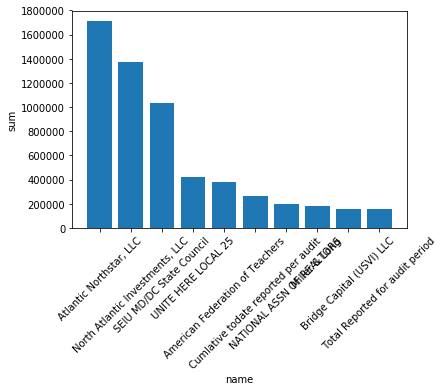

In [37]:
_.bar()

In [38]:
%%sql
SELECT COUNT(contributor.name), contributor.name
FROM contribution_facts
LEFT JOIN contributor
ON contributor.contributor_key = contribution_facts.contributor_key
WHERE contributor.type = 'Corporation'
GROUP BY contributor.name
ORDER BY COUNT(contributor.name) DESC
LIMIT 10

 * postgresql://student@/assignment4
10 rows affected.


count,name
123,SEIU MD/DC State Council
108,"Atlantic Northstar, LLC"
87,SEIU Local 500 Members
55,Verizon
54,Session Law Firm
53,DC Legal
52,HRGM Corporation
49,ROC Action
46,Metropolitan Washington PAC
45,Lottery Technology Enterprises


<BarContainer object of 10 artists>

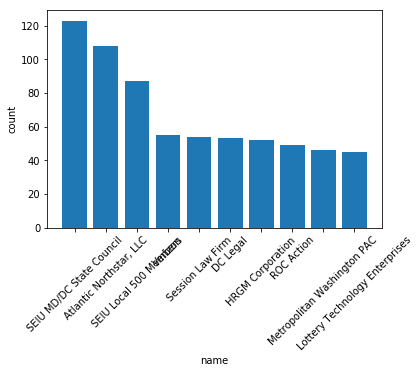

In [39]:
_.bar()

__What does the total contribution look like for each year?__

First, I use an sql query to solve the problem, the result shows that 2014 has the highest amount while 2017 has the lowest amount of contribution. And the contribution amout of 2017 is extemely lower than other years.

In [48]:
%%sql
SELECT campaign.election_year,SUM(contribution_facts.amount)
FROM contribution_facts
LEFT JOIN campaign
ON campaign.campaign_key = contribution_facts.campaign_key
GROUP BY campaign.election_year
ORDER BY campaign.election_year ASC
LIMIT 14

 * postgresql://student@/assignment4
14 rows affected.


election_year,sum
2002,9518388.30
2004,7143687.31
2006,15136070.00
2007,1968907.67
2008,4829248.95
2010,12598725.81
2011,918029.94
2012,4655604.08
2013,1132066.15
2014,16504496.29


<BarContainer object of 14 artists>

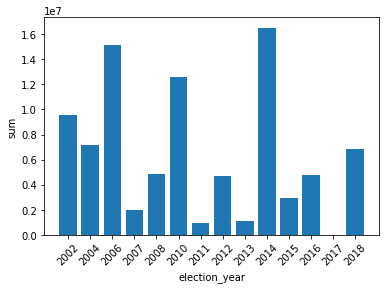

In [41]:
_.bar()

__Verify the reslut using dataframe__

In [42]:
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

Import the data into a dataframe

In [43]:
df = pd.read_csv('dc_contributions.csv')

Using pandas to calculate the amounts of each years. We can see the results is the same by using SQL queries.

In [44]:
year = df['ELECTIONYEAR'].unique().tolist()
amount = []
for i in year:
    df_year = df[df.ELECTIONYEAR == i] 
    amount.append(df_year['AMOUNT'].sum())  
df_year = pd.DataFrame({"year":year,"amount":amount}).sort_values(by=['year']).dropna()
df_year['year'] = df_year['year'].astype(int)
df_year

,amount,year
4,9518388.30,2002
2,7143687.31,2004
5,15136070.00,2006
1,1968907.67,2007
11,4829248.95,2008
10,12598725.81,2010
7,918029.94,2011
8,4655604.08,2012
9,1132066.15,2013
3,16504496.29,2014


Then plot the resluts. The bar plot clearly shows that the contribution amout of 2017 is extemely lower than other years.

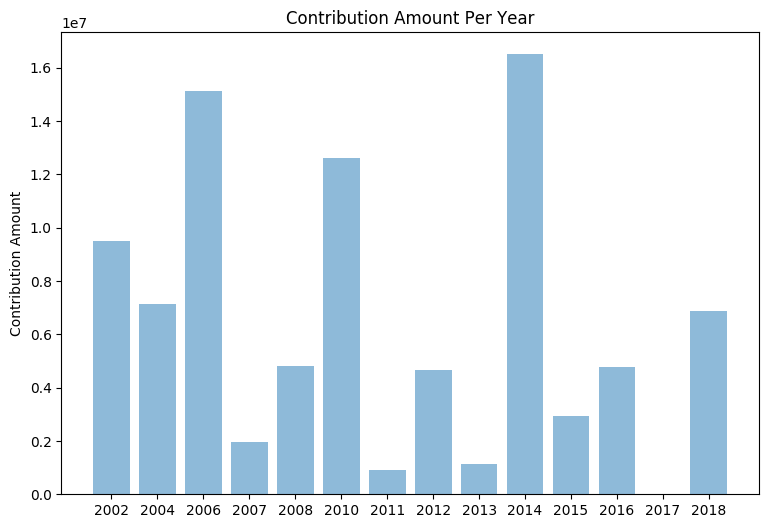

In [45]:
plt.figure(figsize=(9,6))
objects = df_year['year'].tolist()
y_pos = np.arange(len(objects))
performance = df_year['amount'].tolist()
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Contribution Amount')
plt.title('Contribution Amount Per Year')
 
plt.show()

__How much did each contrbution type contributed?__

Not surprisingly, the type PCC has the lagest average number of contribution amount among all 27 types.

In [46]:
%%sql
SELECT AVG(amount), contributor.type
FROM contribution_facts
LEFT JOIN contributor
ON contributor.contributor_key = contribution_facts.contributor_key
GROUP BY contributor.type
ORDER BY AVG(amount) DESC

 * postgresql://student@/assignment4
27 rows affected.


avg,type
26376.890000000000,PCC
18230.4700000000000000,transfer of contributions
7347.2222222222222222,Republican
5000.0000000000000000,A Multicandidate Qualified Committee
4483.5456321839080460,Labor
4295.7618803418803419,Committee
2122.8358369098712446,Other
1895.6313286713286713,Corporate Sponsored PAC
1500.0000000000000000,none
1217.2029629629629630,Democratic


<BarContainer object of 27 artists>

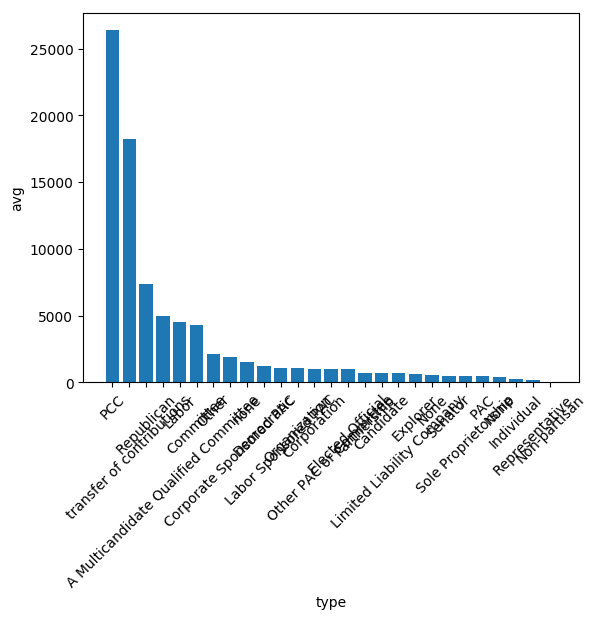

In [47]:
_.bar()